In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.ESRNN import ESRNN
plt.style.use('ggplot')
pd.options.display.max_rows = 999
np.set_printoptions(threshold=np.inf)

In [2]:
# Plot
def plot_prediction(y, y_hat):
    n_y = len(y)
    n_yhat = len(y_hat)
    ds_y = np.array(range(n_y))
    ds_yhat = np.array(range(n_y, n_y+n_yhat))

    plt.plot(ds_y, y, label = 'y')
    plt.plot(ds_yhat, y_hat, label='y_hat')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
def ffill_missing_dates_particular_serie(serie, min_date, max_date, freq):
    date_range = pd.date_range(start=min_date, end=max_date, freq=freq)
    unique_id = serie['unique_id'].unique()
    df_balanced = pd.DataFrame({'ds':date_range, 'key':[1]*len(date_range), 'unique_id': unique_id[0]})

    # Check balance
    check_balance = df_balanced.groupby(['unique_id']).size().reset_index(name='count')
    assert len(set(check_balance['count'].values)) <= 1
    df_balanced = df_balanced.merge(serie, how="left", on=['unique_id', 'ds'])

    df_balanced['y'] = df_balanced['y'].fillna(method='ffill')
    df_balanced['x'] = df_balanced['x'].fillna(method='ffill')


    return df_balanced

def ffill_missing_dates_per_serie(df, freq, fixed_max_date=None):
    """Receives a DataFrame with a date column and forward fills the missing gaps in dates, not filling dates before
    the first appearance of a unique key

    Parameters
    ----------
    df: DataFrame
        Input DataFrame
    key: str or list
        Name(s) of the column(s) which make a unique time series
    date_col: str
        Name of the column that contains the time column
    freq: str
        Pandas time frequency standard strings, like "W-THU" or "D" or "M"
    numeric_to_fill: str or list
        Name(s) of the columns with numeric values to fill "fill_value" with
    """
    if fixed_max_date is None:
        df_max_min_dates = df[['unique_id', 'ds']].groupby('unique_id').agg(['min', 'max']).reset_index()
    else:
        df_max_min_dates = df[['unique_id', 'ds']].groupby('unique_id').agg(['min']).reset_index()
        df_max_min_dates['max'] = fixed_max_date

    df_max_min_dates.columns = df_max_min_dates.columns.droplevel()
    df_max_min_dates.columns = ['unique_id', 'min_date', 'max_date']

    df_list = []
    for index, row in df_max_min_dates.iterrows():
        df_id = df[df['unique_id'] == row['unique_id']]
        df_id = ffill_missing_dates_particular_serie(df_id, row['min_date'], row['max_date'], freq)
        df_list.append(df_id)

    df_dates = pd.concat(df_list).reset_index(drop=True).drop('key', axis=1)[['unique_id', 'ds', 'y','x']]

    return df_dates

In [4]:
# Original stock data
data = pd.read_csv('data/train.csv')
data['Date'] = data['Year'].astype(str)+'-'+data['Date'].astype(str)
data['Date'] = pd.to_datetime(data['Date'])
data = data[['Company','Year','Date','Close']]
data.head()

,Company,Year,Date,Close
0,abbv,2013,2013-01-04,28.810
1,abbv,2013,2013-01-07,28.869
2,abbv,2013,2013-01-08,28.242
3,abbv,2013,2013-01-09,28.399
4,abbv,2013,2013-01-10,28.481


In [5]:
# Clean data (model assumes this name columns)
data['unique_id'] = data['Company']+"_"+data['Year'].astype(str)
data = data.rename(columns={'Date':'ds', 'Close':'y'})
data['x'] = data['Year'].astype(str)
data.head()

,Company,Year,ds,y,unique_id,x
0,abbv,2013,2013-01-04,28.810,abbv_2013,2013
1,abbv,2013,2013-01-07,28.869,abbv_2013,2013
2,abbv,2013,2013-01-08,28.242,abbv_2013,2013
3,abbv,2013,2013-01-09,28.399,abbv_2013,2013
4,abbv,2013,2013-01-10,28.481,abbv_2013,2013


In [6]:
#Series must be complete in the frequency
data = ffill_missing_dates_per_serie(data,'D')

In [7]:
X_train = data[['unique_id','ds','x']]
y_train = data[['unique_id','ds','y']]

In [8]:
esrnn = ESRNN(max_epochs=0, batch_size=1, learning_rate=1e-3, seasonality=30, input_size=30, output_size=30)
esrnn.fit(X_train, y_train, random_seed=1)

========== Training ESRNN ==========

Train finished!


In [9]:
y_test = y_train.loc[y_train['unique_id'].isin(['abbv_2013'])]
y_hat = esrnn.predict(y_test)

y_hat.shape torch.Size([1, 30])
seasonalities.shape torch.Size([1, 331])
n_time 301
output_size 30


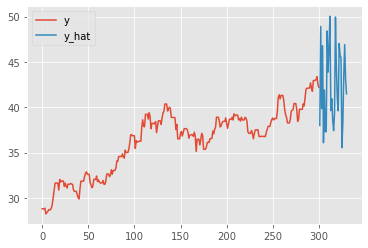

In [10]:
plot_prediction(y_test['y'], y_hat['y_hat'])

In [11]:
esrnn = ESRNN(max_epochs=0, batch_size=8, learning_rate=1e-3, 
              seasonality=7, input_size=7, output_size=28,
              level_variability_penalty=100)
esrnn.fit(X_train, y_train, random_seed=1)

========== Training ESRNN ==========

Train finished!


In [12]:
y_test = y_train.loc[y_train['unique_id'].isin(['abbv_2013'])]
y_hat = esrnn.predict(y_test)

self.seasonality 7
self.output_size 28
seasonalities_stacked.shape torch.Size([1, 308])
start_seasonality_ext 301
end_seasonality_ext 322
seasonalities_stacked.shape torch.Size([1, 315])
y_hat.shape torch.Size([1, 28])
seasonalities.shape torch.Size([1, 315])
n_time 301
output_size 28


RuntimeError: The size of tensor a (28) must match the size of tensor b (14) at non-singleton dimension 1

In [ ]:
plot_prediction(y_test['y'], y_hat['y_hat'])